In [2]:
# 参考
# https://www.kaggle.com/code/alfredmaboa/personality-profile-prediction-team-01/notebook

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('./data/csv/mbti_1.csv')
train_data, test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

In [5]:
train_data.head()

,type,posts
8331,INFP,'this is actually exactly what i expected! :l...
1290,ISTP,"'Nope. Not now, not ever. I'm too busy with ..."
1982,ENFJ,'Yes peace is the absence of conflict - your I...
769,INFP,"'I apologize for the delayed response, but tha..."
8339,INFP,"'Nightglow, I can't even imagine what you must..."


In [6]:
test_data.head()

,type,posts
7814,INFP,"'Macona , it depends if the big family has ext..."
2233,ENFJ,https://www.youtube.com/watch?v=cfg4SC9Nics|||...
7261,INFJ,'@ Heylena. Lol! Compliment accepted. Thank ...
7794,INFJ,"'2pac right|||??? rocket coffin, like packed w..."
2950,INTJ,'The title of this thread is misleading; there...


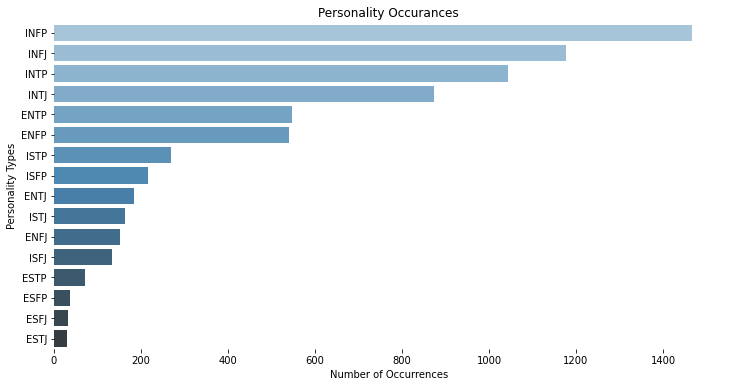

In [7]:
# visualise the occurances/distribution of all the class types.
num_c = train_data['type'].value_counts()
f, ax = plt.subplots(figsize=(12,6))
sns.barplot( num_c.values, num_c.index, palette="Blues_d")
ax.xaxis.grid(False)
ax.set(xlabel="Number of Occurrences")
ax.set(ylabel="Personality Types")
ax.set(title="Personality Occurances")
sns.despine(trim=True, left=True, bottom=True)

In [8]:
train_type = train_data[['type']]
test_type = test_data[['type']]
train_data.drop(['type'], axis=1, inplace=True)
test_data.drop(['type'], axis=1, inplace=True)

In [9]:
# put all the features together to enable quick transformation process
post_features = pd.concat([train_data, test_data],sort=False).reset_index(drop=True)
post_features.head()

,posts
0,'this is actually exactly what i expected! :l...
1,"'Nope. Not now, not ever. I'm too busy with ..."
2,'Yes peace is the absence of conflict - your I...
3,"'I apologize for the delayed response, but tha..."
4,"'Nightglow, I can't even imagine what you must..."


In [10]:
# using regular expressions for dealing with special patterns of noise.
pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
post_features = post_features.replace(to_replace = pattern, value = ' ', regex = True)

In [11]:
post_features.head()

,posts
0,'this is actually exactly what i expected! :l...
1,"'Nope. Not now, not ever. I'm too busy with ..."
2,'Yes peace is the absence of conflict - your I...
3,"'I apologize for the delayed response, but tha..."
4,"'Nightglow, I can't even imagine what you must..."


In [12]:
# creating a cleaned corpus

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lem = WordNetLemmatizer() # returns the actual root word of a text token
# ps = PorterStemmer() # cuts off the surfix but doesnt necessarily return the root word
corpus =[]
# cleaning text
for i in range(0,len(post_features['posts'])):

  post = re.sub('[^a-zA-Z]', ' ',str(post_features.iloc[i].values)) 
  post = post.lower()
  post = post.split()
  # ps.stem(word) #MethodAttempt
  stop_wrds = set(stopwords.words('english'))
  post = [lem.lemmatize(word, "v") for word in post if not word in stop_wrds]
  post = ' '.join(post)
  corpus.append(post)

post_features['posts_clean'] = corpus
post_features.drop(['posts'], axis=1, inplace=True)       

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\squid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\squid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\squid\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
post_features.head()

,posts_clean
0,actually exactly expect laugh introversion ext...
1,nope ever busy work cause adrenaline rush acti...
2,yes peace absence conflict infp friend suxx ha...
3,apologize delay response thank take time share...
4,nightglow even imagine must struggle right dad...


In [14]:
# Create Ranked Statistical Features with TfidfVectorizer, best choice because insignificant words recieve a lower rank
obj = TfidfVectorizer()
post_final_features = obj.fit_transform(post_features['posts_clean'])
print(post_final_features[0])

#AnotherMethodAttempt
# Create Ranked Statistical Features with CountVectorizer has no ranking machanism
# obj = CountVectorizer() 
# post_final_features = obj.fit_transform(post_features['posts_clean']).toarray()
# print(post_final_features[0:5])

  (0, 74333)	0.06395629709917167
  (0, 54596)	0.05059213344813968
  (0, 7357)	0.014547278633472967
  (0, 36785)	0.03536058979580873
  (0, 32128)	0.02631851248805686
  (0, 43714)	0.015264681361843183
  (0, 81160)	0.03383826236764225
  (0, 64886)	0.03630209498967487
  (0, 6332)	0.03772654037445236
  (0, 82139)	0.03957050699148336
  (0, 33618)	0.045605673935774096
  (0, 14174)	0.046683366153462455
  (0, 17908)	0.05183508075651206
  (0, 25521)	0.034087591945694246
  (0, 22555)	0.017247544672459716
  (0, 15429)	0.029273205754348244
  (0, 68783)	0.042535714266810416
  (0, 65852)	0.05657301379986916
  (0, 59934)	0.0523808985758521
  (0, 75301)	0.02314004580075041
  (0, 17989)	0.056526537893329294
  (0, 25508)	0.07541218908431893
  (0, 8173)	0.08196498100027004
  (0, 43949)	0.05758302081976705
  (0, 7345)	0.03454742069210482
  :	:
  (0, 75507)	0.014730160660568436
  (0, 23388)	0.02948849398495125
  (0, 61637)	0.01270225239434989
  (0, 58518)	0.013277817225790035
  (0, 30183)	0.0306514287899442

In [15]:
# label extraction and creating our target variables from personality types
pd.options.mode.chained_assignment = None
yc = pd.DataFrame(train_type['type'])
train_type['I-E'] = train_type['type'].astype(str).str[0]
train_type['I-E'] = train_type['I-E'].map({"I": 0, "E": 1})
train_type['S-N'] = train_type['type'].astype(str).str[1]
train_type['S-N'] = train_type['S-N'].map({"S": 0, "N": 1})
train_type['F-T'] = train_type['type'].astype(str).str[2]
train_type['F-T'] = train_type['F-T'].map({"F": 0, "T": 1})
train_type['P-J'] = train_type['type'].astype(str).str[3]
train_type['P-J'] = train_type['P-J'].map({"P": 0, "J": 1})
train_type.drop('type', axis=1, inplace=True) 
y = train_type
print(y[0:5])

      I-E  S-N  F-T  P-J
8331    0    1    0    0
1290    0    0    1    0
1982    1    1    0    1
769     0    1    0    0
8339    0    1    0    0


In [16]:
y = np.array(y)
print(y[0:5])

[[0 1 0 0]
 [0 0 1 0]
 [1 1 0 1]
 [0 1 0 0]
 [0 1 0 0]]


In [17]:
# Spliting the data back to train(X,y) and test(X_sub)
X = post_final_features[:len(y), :]
X_final_test = post_final_features[len(y):, :]
print('Features size for train(X,y) and test(X_final_test):')
print('X', X.shape, 'y', y.shape, 'X_final_test', X_final_test.shape)

Features size for train(X,y) and test(X_final_test):
X (6940, 85754) y (6940, 4) X_final_test (1735, 85754)


In [18]:
# Predicting model
model = OneVsRestClassifier(LogisticRegressionCV(Cs=30, solver = 'saga',
                                                       multi_class = 'multinomial', cv=5), n_jobs =-1)

In [19]:
# split the train set to create a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [20]:
# train model with 80% of train set
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=30, cv=5,
                                                   multi_class='multinomial',
                                                   solver='saga'),
                    n_jobs=-1)

In [21]:
# predict 20% of train set
y_pred = model.predict(X_test)

In [22]:
# performance matrics and model eveluation using sklearn.metrics inbuilt classification metric
print(classification_report(y_test, y_pred, target_names=['Mind', 'Energy', 'Nature', 'Tactics']))

              precision    recall  f1-score   support

        Mind       0.73      0.55      0.63       322
      Energy       0.91      0.99      0.95      1196
      Nature       0.83      0.85      0.84       626
     Tactics       0.82      0.59      0.69       554

   micro avg       0.86      0.82      0.84      2698
   macro avg       0.82      0.74      0.78      2698
weighted avg       0.85      0.82      0.83      2698
 samples avg       0.85      0.82      0.81      2698



In [23]:
# Reinitialise final model
model = OneVsRestClassifier(LogisticRegressionCV(Cs=30, solver = 'saga',
                                                 multi_class = 'multinomial', cv=10), n_jobs =-1)

In [24]:
# train final model with full train set 
model.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=30, cv=10,
                                                   multi_class='multinomial',
                                                   solver='saga'),
                    n_jobs=-1)

In [25]:
# pridicting the actual test set (X_final_test)
y_predicted = model.predict(X_final_test)

In [26]:
# Final model results
print(y_predicted[0:5])

[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 1]
 [0 1 1 0]]


In [27]:
def changeNumToMBTI(ar_lbl):
  result = ''
  if ar_lbl[0] == 0:
    result += 'I'
  else:
    result += 'E'

  if ar_lbl[1] == 0:
    result += 'S'
  else:
    result += 'N'
    
  if ar_lbl[2] == 0:
    result += 'F'
  else:
    result += 'T'

  if ar_lbl[3] == 0:
    result += 'P'
  else:
    result += 'J'
    
  return result

In [29]:
def getMBTI(msg):
  words_vec = obj.transform([msg]).toarray()
  return changeNumToMBTI(words_vec[0])

In [31]:
# momoka ENFP
# session10 5min
print(getMBTI("Certainly, with today's technology, I think you don't have to go and see them anymore to see them in a great way, but then I thought, why did you bring them here at the zoo? But then, why did you come to the zoo? Plus, the zoo fees are fairly inexpensive, but it would probably cost a fair amount of money to go and see the animals in person, or to use the equipment. I thought that the zoo was created to make it easy to see the animals. What do you think? I don't know. I don't know. Yes, I think that the loss of the wild function would take away the good parts of the animal. Nowadays, people talk about the importance of individuality, so I wonder if that is part of it."))
print(getMBTI(open("./data/text/lookback/momoka_en.txt", "r", encoding='UTF-8').read()))

ISFP
ISFP


In [32]:
# issei ESFJ session10
print(getMBTI("Yes, for three weeks, but the reason for this is that I think zoos also have the role of protecting animals, and animals that cannot live on their own due to the harsh environment, global warming, deforestation, etc., have a difficult time living in zoos. I wondered which of the two was more necessary. I think it is true that humans are responsible for the destruction of the environment, but I also believe that it is because of the actions of the next generation of humans that we are able to protect the environment."))
print(getMBTI(open("./data/text/lookback/issei_en.txt", "r", encoding='UTF-8').read()))

ISFP
ISFP


In [33]:
# kai ESFP session10
print(getMBTI("Yes, I am. I would like to hear the opinions of those who are in favor of the zoo first. I see. Thank you very much. Do you have any questions for the main section? I see. Thank you very much. I think that one of the opinions of the proponents is the protection of animals, and the other is that people will be interested in animals when they see them. Then I would like to move on to 3, the opponents' opinions. I see. Thank you very much. I would like to speak next, but I think my opinion would be a bit like a rebuttal to your opinion, but nowadays, various technologies have developed. In the past, there was little such technology, and many people had no choice but to go and see the animals in person, or there was nothing to see even if they took pictures of the animals. I think the value of zoos was high as a place to learn about things, but nowadays there are a lot of resources available, and I think it's fine not to go to the trouble of putting animals in a zoo and observing them, but it's easy to do so. I think it is better to casually take animals that are living in the wild and view them in that way than to put them in a world that is like a prison, and I think it is better for me to study them. So, you know, one thing I disagree with is your reaction. I also responded to Momoka's opinion, saying that there must be some way to learn about animals or to get people interested in them, even if it is not in an individual zoo. I would like to ask you, Mr. Ishii, if you have any objections or even sympathies for Mr. Keita's opinion, that you heard earlier, that would be totally fine. Do you have any?"))
print(getMBTI(open("./data/text/lookback/kai_en.txt", "r", encoding='UTF-8').read()))

ISFP
ISFP


In [34]:
# keito ENFP session10
print(getMBTI("The opponents' point of view is protection, but it was humans who created the conditions that made it necessary to reinforce the situation in the first place, and it was not humans who experienced all the environmental destruction and global warming. For example, in the case of global warming, it was exhaust emissions, deforestation, and wages for the land needed to build towns and cities, but the animals could no longer live there, so we said we would build zoos and protect them. But only a small percentage of the animals can be protected, and all the animals living in the logged area cannot be sent to the zoo, so they are driven away. So, I think that what the zoo has created is only English for humans, and that's why I have this opinion. It's a different opposing opinion. Yeah."))
print(getMBTI(open("./data/text/lookback/keito_en.txt", "r", encoding='UTF-8').read()))

ISFP
ISFP
